# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Basic libraries
#
import random
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing   import StandardScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow                as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks  import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils      import plot_model

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User libraries
#
from utils.metrics      import PEHE, ATE
from utils.Loss         import *
from utils.DragonNet    import *
from utils.utils        import MSE
from utils.dataloader   import *

print('[INFO] All libraries were imported')

[INFO] All libraries were imported


# Parameters

In [2]:
# 1. Linear (linear)
# 2. Nonlinear (sin)
# 3. Normally distributed x, linearly independent (lin_ind_normal)
# 4. Non-normally distributed x, linearly independent (lin_ind_mixed)
# 5. Non-normally distributed x, with dependecies & linear correlations (lin_corr_mixed)
# 6. Non-normally distributed x, with dependecies & linear correlations (corr_interactions))

Problem = 'Synthetic'
problem_type = 'lin_ind_normal'
train_size = 0.8
n_f, n_i = 10, 5
nInstances = 1000 # size
p = 0.3
seed = 42

Model = 'Dragonnet'



random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed) 
# tf.random.set_random_seed(seed) # for Tensoflow v1

In [3]:
targeted_regularization    = True # {True, False}

output_dir                 = ''
knob_loss                  = dragonnet_loss_binarycross
ratio                      = 1.
validation_split           = 0.2
batch_size                 = 64
verbose                    = False




metrics = [regression_loss, binary_classification_loss, treatment_accuracy, track_epsilon]

if targeted_regularization:
    loss = make_tarreg_loss(ratio=ratio, dragonnet_loss=knob_loss)
else:
    loss = knob_loss

In [4]:
DataLoader = Synthetic(type=problem_type, size=nInstances, n_f=n_f, n_i=n_i, p=p, seed=seed)
DataLoader.create_dataset(train_size=0.8)

# Simulations

In [5]:
# Start timer
#
start1 = time.time()


# Load training data
#
trainX, trainT, trainY, train_potential_Y = DataLoader.get_training_data()

# Load testing data
#
testX, testT, testY, test_potential_Y = DataLoader.get_testing_data()
#
print('[INFO] Datasets imported')


# Setup scaler for inputs
scalerX = StandardScaler()
trainX  = scalerX.fit_transform( trainX )
testX   = scalerX.transform( testX )




# Setup DragonNet
#
dragonnet = make_dragonnet(trainX.shape[1], 0.01)


# Create outputs for DragonNet (concatenate Y & T)
#
yt_train = np.concatenate([trainY.reshape(-1,1), trainT.reshape(-1,1)], axis = 1)


#
#
# *** Training - Phase I ***
#
#

# Compile network
#
dragonnet.compile(optimizer = Adam(lr=1e-3), 
                    loss      = loss, 
                    metrics   = metrics)

# Setup callbacks
callbacks = [TerminateOnNaN(),
                EarlyStopping(monitor   = 'val_loss', 
                            patience  = 2, 
                            min_delta = 0.),
                ReduceLROnPlateau(monitor   = 'loss', 
                                factor    = 0.5, 
                                patience  = 5, 
                                verbose   = verbose, 
                                mode      = 'auto', 
                                min_delta = 1e-8, 
                                cooldown  = 0, 
                                min_lr    = 0)]

start_time = time.time()

# Training
#
dragonnet.fit(trainX, yt_train, 
                callbacks        = callbacks,
                validation_split = validation_split,
                epochs           = 100,
                batch_size       = batch_size, 
                verbose          = verbose)


print("[INFO] Training - Phase I - Time %.2f secs" % (time.time() - start_time) )







#
#
# *** Training - Phase II ***
#
#    

# Setup callbacks
#
callbacks = [TerminateOnNaN(),
                EarlyStopping(monitor   = 'val_loss', 
                            patience  = 40, 
                            min_delta = 0.),
                ReduceLROnPlateau(monitor   = 'loss', 
                                factor    = 0.5, 
                                patience  = 5, 
                                verbose   = verbose, 
                                mode      = 'auto',
                                min_delta = 0., 
                                cooldown  = 0, 
                                min_lr    = 0)
]

# Compile network
#
dragonnet.compile(optimizer = SGD(lr=1e-5, momentum=0.9, nesterov=True), 
                    loss      = loss,
                    metrics   = metrics)




start_time = time.time()

# Training
#
dragonnet.fit(trainX, yt_train, 
                callbacks        = callbacks,
                validation_split = validation_split,
                epochs           = 300,
                batch_size       = batch_size, 
                verbose          = verbose)

print("[INFO] Training - Phase II - Time %.2f secs" % (time.time() - start_time) )





#
#
# *** Predictions ***
#
#       
yt_hat_test  = dragonnet.predict( testX, verbose=False )

# Get predictions
#
test_y_hat = yt_hat_test[:,:2]


# Get propensity score
#
propensity_score = yt_hat_test[:,2]




# Results
Results = dict()
Results['Error_PEHE'] = PEHE(test_potential_Y, test_y_hat)
Results['Error_ATE'] = ATE(test_potential_Y, test_y_hat)  
Results['MSE_0'] = MSE(test_potential_Y[:,0], test_y_hat[:,0])
Results['MSE_1'] = MSE(test_potential_Y[:,1], test_y_hat[:,1])

    
print('[INFO] Error of PEHE and ATE computed')
print('[INFO] Time %.2f\n\n' % (time.time() - start1))

[INFO] Datasets imported
[INFO] Training - Phase I - Time 8.94 secs
[INFO] Training - Phase II - Time 11.63 secs
[INFO] Error of PEHE and ATE computed
[INFO] Time 21.63




In [6]:
import json
filename = f'Results/Problem={Problem}-{problem_type}-{p}_Model={Model}.json'

with open(filename, "w") as outfile:
    json.dump(Results, outfile)

Results

{'Error_PEHE': 1.0631333058856498,
 'Error_ATE': 0.01261586002276184,
 'MSE_0': 1.0234520767506128,
 'MSE_1': 1.851718507060192}

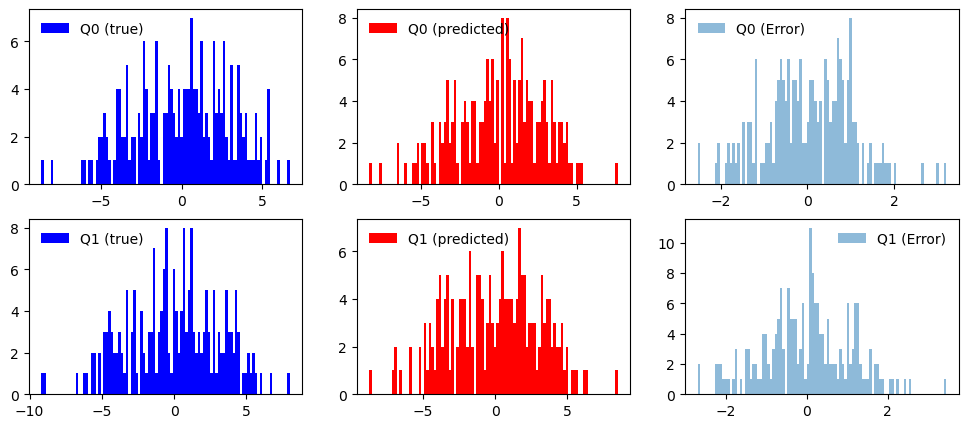

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(12,5) )

ax[0][0].hist(test_potential_Y[:,0], bins=100, color='blue');
ax[0][1].hist(yt_hat_test[:,0], bins=100, color='red');
ax[0][2].hist(yt_hat_test[:,0] - test_potential_Y[:,0], bins=100, color='tab:blue', alpha = 0.5);

ax[1][0].hist(test_potential_Y[:,1], bins=100, color='blue');
ax[1][1].hist(yt_hat_test[:,1], bins=100, color='red');
ax[1][2].hist(yt_hat_test[:,1] - test_potential_Y[:,0], bins=100, color='tab:blue', alpha = 0.5);

ax[0][0].legend(['Q0 (true)'], frameon=False);
ax[0][1].legend(['Q0 (predicted)'], frameon=False);
ax[0][2].legend(['Q0 (Error)'], frameon=False);

ax[1][0].legend(['Q1 (true)'], frameon=False);
ax[1][1].legend(['Q1 (predicted)'], frameon=False);
ax[1][2].legend(['Q1 (Error)'], frameon=False);

fig.savefig(f'images/Problem={Problem}-{problem_type}-{p}_Model={Model}.png', dpi=100, transparent=True)

# Feature Importance

## Permutation Feature Importance

In [8]:
# Set feature names
Features = [f'X{i+1}' for i in range(testX.shape[1])]

# Number of Iteration for Permutation-Feature-Importance
nSimulations = 100

In [9]:
from tqdm import tqdm

Performance = {'Error_PEHE': [], 'Error_ATE': [], 'MSE_0': [], 'MSE_1':  [], 'Feature': [], 'Iteration': []}

# Features
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
for i in range(testX.shape[1]):
    print('Feature: ', Features[i])

    for Sim in tqdm(range(nSimulations)):
        testX_new = testX.copy()
        
        # Shuffle Feature-i
        np.random.shuffle(testX_new[:,0])

        # Get predictions
        yt_hat_test  = dragonnet.predict( testX_new, verbose=False )
        test_y_hat = yt_hat_test[:,:2]

        # Include Feature performance
        Performance['Error_PEHE'] += [PEHE(test_potential_Y, test_y_hat)]
        Performance['Error_ATE'] += [ATE(test_potential_Y, test_y_hat)  ]
        Performance['MSE_0'] += [MSE(test_potential_Y[:,0], test_y_hat[:,0])]
        Performance['MSE_1'] += [MSE(test_potential_Y[:,1], test_y_hat[:,1])]
        Performance['Feature'] += [Features[i]]
        Performance['Iteration'] += [Sim]

Feature:  X1


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


Feature:  X2


100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


Feature:  X3


100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


Feature:  X4


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Feature:  X5


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Feature:  X6


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


Feature:  X7


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


Feature:  X8


100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Feature:  X9


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Feature:  X10


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


In [10]:
df = pd.DataFrame.from_dict(Performance)

for performanceMetric in ['Error_PEHE', 'Error_ATE', 'MSE_0', 'MSE_1']:
    df[performanceMetric] = df[performanceMetric] - Results[performanceMetric]


df.to_csv(f'PFI/Problem={Problem}-{problem_type}-{p}_Model={Model}.csv', index = False)

## Shap

In [11]:
import shap
explainer = shap.DeepExplainer(dragonnet, trainX)

shap_values = explainer.shap_values(testX)

np.savez(f'SHAP/Problem={Problem}-{problem_type}-{p}_Model={Model}.npz', shap_values=shap_values, Features=np.array(Features))
print('[INFO] SHAP values calculated')

[INFO] SHAP values calculated
